In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, GenericUnivariateSelect
from functools import partial
import pandas as pd


plt.set_loglevel("warning")

%reload_ext autoreload
%autoreload 2

In [2]:
housing_train = make_dataset.load_data(
    conf.ROOT_DATA_DIR, conf.DataDirectory.INTERIM, "housing_train_prepared.csv"
)
housing_train = housing_train.drop("index", axis=1)
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15710 entries, 0 to 15709
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15710 non-null  float64
 1   latitude            15710 non-null  float64
 2   housing_median_age  15710 non-null  float64
 3   total_rooms         15710 non-null  float64
 4   total_bedrooms      15710 non-null  float64
 5   population          15710 non-null  float64
 6   households          15710 non-null  float64
 7   median_income       15710 non-null  float64
 8   ocean_proximity     15710 non-null  object 
 9   median_house_value  15710 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


## Rooms and bedrooms

Rooms and bedrooms information are given as total for each neighboorhood. Let's see if bringing these information to ratios is more relevant.

In [3]:
housing_train["rooms_per_household"] = (
    housing_train["total_rooms"] / housing_train["households"]
)
housing_train["bedrooms_per_household"] = (
    housing_train["total_bedrooms"] / housing_train["households"]
)
housing_train["bedrooms_room_ratio"] = (
    housing_train["total_bedrooms"] / housing_train["total_rooms"]
)
housing_train.corr()["median_house_value"].abs().sort_values(ascending=False)

median_house_value        1.000000
median_income             0.639130
bedrooms_room_ratio       0.211039
latitude                  0.153612
total_rooms               0.143403
rooms_per_household       0.127993
households                0.097519
total_bedrooms            0.078019
bedrooms_per_household    0.070540
housing_median_age        0.066640
longitude                 0.041276
population                0.012417
Name: median_house_value, dtype: float64

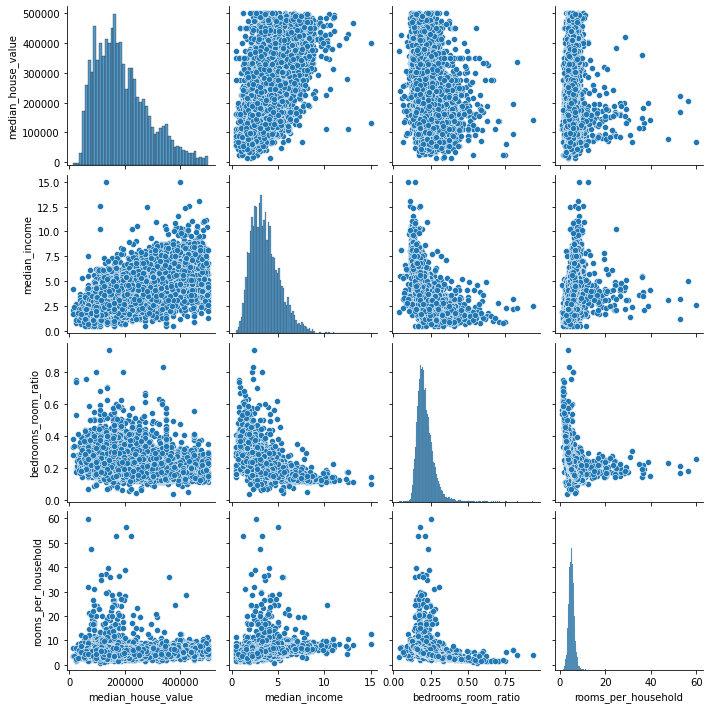

In [4]:
sns.pairplot(
    housing_train.loc[
        :,
        [
            "median_house_value",
            "median_income",
            "bedrooms_room_ratio",
            "rooms_per_household",
        ],
    ]
)

## Univariate feature model_selection

In [5]:
from sklearn.compose import make_column_selector
import numpy as np

l = make_column_selector(dtype_include=np.number)
housing_train[l(housing_train)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,bedrooms_room_ratio
0,-117.85,33.88,14.0,4753.0,681.0,2138.0,678.0,7.3658,288500.0,7.010324,1.004425,0.143278
1,-121.92,37.32,28.0,2089.0,641.0,1666.0,587.0,2.3633,198400.0,3.558773,1.091993,0.306845
2,-122.12,37.41,33.0,2892.0,617.0,1250.0,581.0,5.3727,360900.0,4.977625,1.061962,0.213347
3,-118.37,33.99,32.0,4018.0,564.0,1400.0,568.0,8.6718,439100.0,7.073944,0.992958,0.140368
4,-118.49,34.24,34.0,1971.0,316.0,917.0,307.0,6.0965,262300.0,6.420195,1.029316,0.160325


In [15]:
preprocessor = preprocessing.make_preprocessor()
preprocessor.fit_transform(housing_train)

array([[ 0.85822084, -0.82634361, -1.15384947, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17510733,  0.77463811, -0.03391773, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27502518,  0.81652426,  0.36605789, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.60343033, -0.64949098,  0.44605302, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.21792509, -1.36620954,  1.88596525, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.8232496 , -0.89149984, -0.83386897, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# One-hot encoding of ocean_proximity
housing_train_enc = pd.concat(
    [housing_train, pd.get_dummies(housing_train["ocean_proximity"])], axis=1
).drop("ocean_proximity", axis=1)

discrete_features = housing_train.columns.get_indexer(
    [
        "longitude",
        "latitude",
        "housing_median_age",
        *(housing_train["ocean_proximity"].unique()),
    ]
)

In [ ]:
def mir_score_with_discrete_columns(discrete_features):
    """Partial MIR function with discrete_features defined so that we can use it
    in sklearn feature selectors such as SelectKBest"""

    return partial(
        mutual_info_regression, discrete_features=discrete_features, random_state=0
    )

In [ ]:
feature_selector = GenericUnivariateSelect(
    mir_score_with_discrete_columns(discrete_features)
)
feature_selector.fit(
    housing_train_enc.drop("median_house_value", axis=1),
    housing_train_enc["median_house_value"],
)
for score, feature in sorted(
    zip(feature_selector.scores_, feature_selector.feature_names_in_), reverse=True
):
    print(feature, score)

longitude 0.42878003018704103
latitude 0.3984420509230411
median_income 0.33188939009261986
INLAND 0.19133236517634766
bedrooms_room_ratio 0.10843637774261161
<1H OCEAN 0.10470825783372995
rooms_per_household 0.07291053310249218
total_rooms 0.0424170024748145
households 0.03079707567200618
housing_median_age 0.029066707683598203
total_bedrooms 0.02605427131337379
population 0.023909229257814246
bedrooms_per_household 0.023249442795666653
NEAR OCEAN 0.014830670519043299
NEAR BAY 0.009158376634348375
ISLAND 0.0067179857903145734


## Feature scaling

In [ ]:
scaler = StandardScaler()
housing_train_scaled = pd.DataFrame(
    scaler.fit_transform(housing_train_enc), columns=housing_train_enc.columns
)